# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
!pip install -Uq scikit-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Lasso

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor

## Подготовка данных

### Изучение данных

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

<b>Имеются пропущенные значения.</b>

<b>Признаки NumberOfPictures, PostalCode неинформативные. DateCrawled повторяет информацию из DateCreated. Признак RegistrationMonth по сути не влияет на цену автомобиля.</b>

In [6]:
data = data.drop(['NumberOfPictures', 'PostalCode', 'RegistrationMonth', 'DateCrawled', 'DateCreated'], axis=1)

In [7]:
num_features = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'LastSeen']
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired', 'Brand']

<b>Разделим признаки на количественные и категориальные.</b>

### Подготовка даных

<b>Удалим дубликаты.</b>

In [9]:
data = data.drop_duplicates()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354256 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354256 non-null  int64 
 1   VehicleType       316766 non-null  object
 2   RegistrationYear  354256 non-null  int64 
 3   Gearbox           334424 non-null  object
 4   Power             354256 non-null  int64 
 5   Model             334552 non-null  object
 6   Kilometer         354256 non-null  int64 
 7   FuelType          321364 non-null  object
 8   Brand             354256 non-null  object
 9   Repaired          283107 non-null  object
 10  LastSeen          354256 non-null  object
dtypes: int64(4), object(7)
memory usage: 32.4+ MB


#### Price

<b>Посмотрим, сколько строчек содержит нулевое значение нашего целевого признака price и удалим их.</b>

In [11]:
len(data[data['Price'] == 0])

10771

<b>Возможно, продавцы не указали цену в объявлении, или произошла какая-то техническая ошибка во время заполнения данных.</b>

In [12]:
data = data[data['Price'] != 0]

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343485 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             343485 non-null  int64 
 1   VehicleType       309735 non-null  object
 2   RegistrationYear  343485 non-null  int64 
 3   Gearbox           326131 non-null  object
 4   Power             343485 non-null  int64 
 5   Model             325965 non-null  object
 6   Kilometer         343485 non-null  int64 
 7   FuelType          314028 non-null  object
 8   Brand             343485 non-null  object
 9   Repaired          277624 non-null  object
 10  LastSeen          343485 non-null  object
dtypes: int64(4), object(7)
memory usage: 31.4+ MB


<b>Посмотрим на гистограмму Price</b>

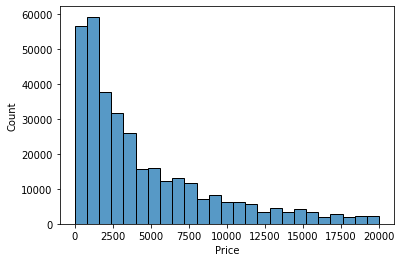

In [14]:
sns.histplot(data['Price'], bins=25);

<b>Данные, в принципе, распределены нормально.</b>

#### Model

<b>Посмотрим, сколько строчек содержат пропуски в признаке Model. Признак Model является одним самых важных признаков для Price, и нельзя никак адекватно восстановить пропуски, поэтому удалим их.</b>

In [15]:
len(data[data['Model'].isna()])

17520

In [16]:
data = data[~data['Model'].isna()]

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325965 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             325965 non-null  int64 
 1   VehicleType       297799 non-null  object
 2   RegistrationYear  325965 non-null  int64 
 3   Gearbox           311696 non-null  object
 4   Power             325965 non-null  int64 
 5   Model             325965 non-null  object
 6   Kilometer         325965 non-null  int64 
 7   FuelType          302416 non-null  object
 8   Brand             325965 non-null  object
 9   Repaired          267677 non-null  object
 10  LastSeen          325965 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.8+ MB


#### Power

<AxesSubplot:>

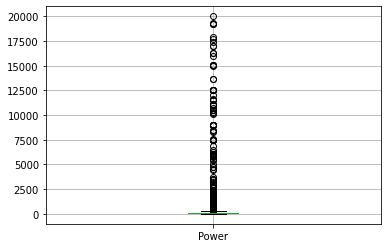

In [18]:
data.boxplot('Power')

<b>Если честно, значение мощности больше даже 1000 лошадиных сил звучит очень неправдоподобно. Заполним неправдоподобные значения медианой значений тех же моделей (То есть допустим у нас есть модель машины, у которой неправдоподобное значение, мы возьмём и заменим это значение медианой значений машин, у которых та же модель).</b>

In [19]:
data.loc[(data['Power'] > 1000) | (data['Power'] == 0), 'Power'] = None
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))
# Проверим, точно ли не осталось пропусков
data = data[~data['Power'].isna()]
data['Power'] = data['Power'].astype('int64')

<b>Также присвоим признаку обратно тип данных int64.</b>

<AxesSubplot:xlabel='Power', ylabel='Count'>

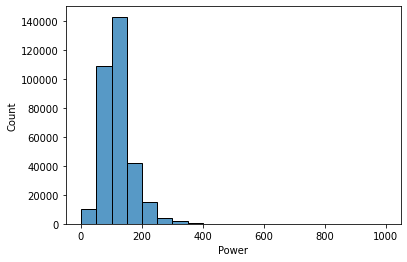

In [20]:
sns.histplot(data['Power'], bins=20)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325964 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             325964 non-null  int64 
 1   VehicleType       297798 non-null  object
 2   RegistrationYear  325964 non-null  int64 
 3   Gearbox           311695 non-null  object
 4   Power             325964 non-null  int64 
 5   Model             325964 non-null  object
 6   Kilometer         325964 non-null  int64 
 7   FuelType          302415 non-null  object
 8   Brand             325964 non-null  object
 9   Repaired          267677 non-null  object
 10  LastSeen          325964 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.8+ MB


#### RegistrationYear

<b>Посмотрим, сколько строк с неправильным годом содержатся в датасете и удалим их.</b>

<AxesSubplot:>

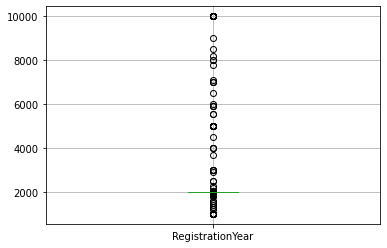

In [22]:
data.boxplot('RegistrationYear')

In [23]:
len(data[data['RegistrationYear'] > 2025])

58

In [24]:
data = data[(data['RegistrationYear'] < 2025) & (data['RegistrationYear'] > 1900)]

In [25]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,LastSeen
0,480,NaN,1993,manual,101,golf,150000,petrol,volkswagen,NaN,2016-04-07 03:16:57
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-04-05 12:47:46
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 17:40:17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-04-06 10:17:21
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,2016-04-06 19:17:07


#### VehicleType, Gearbox, FuelType

<b>Такие признаки будут одинаковыми у одинаковых моделей, поэтому заменим пропуски значениями тех же моделей.</b>

In [26]:
data['VehicleType'] = data['VehicleType'].fillna(data.groupby('Model')['VehicleType']
                                                    .transform(lambda x: x.value_counts().idxmax())
                                                 )

In [27]:
data['Gearbox'] = data['Gearbox'].fillna(data.groupby('Model')['VehicleType']
                                         .transform(lambda x: x.value_counts().idxmax())
                                        )

In [28]:
data['FuelType'] = data['FuelType'].fillna(data.groupby('Model')['VehicleType']
                                           .transform(lambda x: x.value_counts().idxmax())
                                          )

#### Repaired

In [29]:
data['Repaired'] = data['Repaired'].fillna('no_info')

<b>Посмотрим на получившийся датасет.</b>

In [30]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,LastSeen
0,480,sedan,1993,manual,101,golf,150000,petrol,volkswagen,no_info,2016-04-07 03:16:57
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no_info,2016-04-05 12:47:46
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 17:40:17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-04-06 10:17:21
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,2016-04-06 19:17:07


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325878 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             325878 non-null  int64 
 1   VehicleType       325878 non-null  object
 2   RegistrationYear  325878 non-null  int64 
 3   Gearbox           325878 non-null  object
 4   Power             325878 non-null  int64 
 5   Model             325878 non-null  object
 6   Kilometer         325878 non-null  int64 
 7   FuelType          325878 non-null  object
 8   Brand             325878 non-null  object
 9   Repaired          325878 non-null  object
 10  LastSeen          325878 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.8+ MB


#### Разделение на выборки

In [32]:
X = data.drop(['Price', 'LastSeen'], axis=1)
y = data['Price']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
X_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
288021,wagon,2017,manual,143,a4,150000,petrol,audi,no
254064,wagon,1999,manual,75,golf,150000,petrol,volkswagen,no
68359,other,1999,manual,170,3er,150000,petrol,bmw,no
239531,sedan,1996,manual,125,a3,150000,petrol,audi,yes
130439,small,2006,manual,80,corsa,70000,petrol,opel,no


In [35]:
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
311968,small,1997,manual,75,golf,150000,petrol,volkswagen,no
321128,bus,1996,manual,77,transporter,150000,gasoline,volkswagen,no
237243,bus,2003,manual,102,transporter,150000,gasoline,volkswagen,no
215318,sedan,1996,manual,122,c_klasse,150000,petrol,mercedes_benz,no_info
171793,bus,2017,manual,140,b_klasse,125000,gasoline,mercedes_benz,no


#### Кодирование категориальных признаков для LightGBM

In [36]:
encoder_oe = OrdinalEncoder()

X_train_oe = encoder_oe.fit_transform(X_train[cat_features])
X_test_oe = encoder_oe.transform(X_test[cat_features])

In [37]:
encoder_col_names = encoder_oe.get_feature_names_out()

X_train_oe = pd.DataFrame(X_train_oe, columns = encoder_col_names)
X_test_oe = pd.DataFrame(X_test_oe, columns = encoder_col_names)

#### Кодирование категориальных признаков для Lasso

In [38]:
encoder_ohe = OneHotEncoder(drop='first', sparse_output=False)

X_train_ohe = encoder_ohe.fit_transform(X_train[cat_features])
X_test_ohe = encoder_ohe.transform(X_test[cat_features])

In [39]:
encoder_col_names = encoder_ohe.get_feature_names_out()

X_train_ohe = pd.DataFrame(X_train_ohe, columns = encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns = encoder_col_names)

#### Кодирование количественных признаков

In [40]:
scaler = StandardScaler()
lst = ['RegistrationYear', 'Power', 'Kilometer']

X_train_scaled = scaler.fit_transform(X_train[lst])
X_test_scaled = scaler.transform(X_test[lst])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=lst)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=lst)

<b>Посмотрим на наши итоговые выборки.</b>

In [41]:
X_train = pd.concat([X_train_oe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_oe, X_test_scaled], axis=1)

In [42]:
X_train_1 = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_1 = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [43]:
X_train_1

,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_bus,Gearbox_convertible,Gearbox_coupe,...,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,RegistrationYear,Power,Kilometer
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.887703,-0.828652,0.577918
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.029410,-0.791033,0.577918
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.037457,-0.320787,0.577918
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.029410,0.055410,0.577918
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.946448,0.393987,-0.098949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244403,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037457,-0.189118,0.577918
244404,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.529373,0.958282,-0.098949
244405,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.879655,-1.223659,0.577918
244406,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.887703,-0.546505,0.577918


## Обучение моделей

### Lasso

In [54]:
model = Lasso()

In [55]:
param = {'alpha': [1]}

In [56]:
grid_search_RMSE = GridSearchCV(model,param_grid=param,scoring ='neg_root_mean_squared_error',cv=2)
grid_search_RMSE.fit(X_train_1, y_train)

GridSearchCV(cv=2, estimator=Lasso(), param_grid={'alpha': [1]},
             scoring='neg_root_mean_squared_error')

In [57]:
pd.DataFrame(grid_search_RMSE.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,88.916868,28.389951,0.225241,0.00359,1,{'alpha': 1},-2727.699722,-2719.062036,-2723.380879,4.318843,1


### LightGBM

In [58]:
train_data = lgb.Dataset(X_train, label=y_train)

test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [59]:
# Define a dictionary of parameters for configuring the LightGBM regression model.
params = {
    'objective': ['regression'],
    'metric': ['rmse'],
    'num_leaves': [31],
    'learning_rate': [0.05],
    'feature_fraction': [0.9],
    'random_state': [42]
}

In [60]:
%%time
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[
                train_data], early_stopping_rounds=10)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.401883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 244408, number of used features: 9
[LightGBM] [Info] Start training from score 4618.429037
[1]	training's rmse: 4370.46
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 4218.34
[3]	training's rmse: 4075.77
[4]	training's rmse: 3943.11
[5]	training's rmse: 3828.91
[6]	training's rmse: 3727.55
[7]	training's rmse: 3614.69
[8]	training's rmse: 3507.78
[9]	training's rmse: 3409.12
[10]	training's rmse: 3329.47
[11]	training's rmse: 3246.59
[12]	training's rmse: 3175.46
[13]	training's rmse: 3095.4
[14]	training's rmse: 3020.9
[15]	training's rmse: 2952.68
[16]	training's rmse: 2887.05
[17]	training's rmse: 2826.56
[18]	training's rmse: 2769.33
[19]	training's rmse: 2714.15
[20]	training's rmse: 2662.68
[21

In [61]:
model = LGBMRegressor(metric='rmse')

In [63]:
grid_search_RMSE = GridSearchCV(model,param_grid=params,scoring ='neg_root_mean_squared_error',cv=5)
grid_search_RMSE.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


GridSearchCV(cv=5, estimator=LGBMRegressor(metric='rmse'),
             param_grid={'feature_fraction': [0.9], 'learning_rate': [0.05],
                         'metric': ['rmse'], 'num_leaves': [31],
                         'objective': ['regression'], 'random_state': [42]},
             scoring='neg_root_mean_squared_error')

In [64]:
pd.DataFrame(grid_search_RMSE.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_fraction,param_learning_rate,param_metric,param_num_leaves,param_objective,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,39.692064,67.448311,0.482781,0.037654,0.9,0.05,rmse,31,regression,42,"{'feature_fraction': 0.9, 'learning_rate': 0.0...",-1823.301464,-1806.343111,-1807.018927,-1808.290117,-1794.840858,-1807.958895,9.067318,1


In [65]:
%%time
y_test1 = grid_search_RMSE.predict(X_test)

CPU times: user 782 ms, sys: 0 ns, total: 782 ms
Wall time: 770 ms


In [66]:
print('Testing RMSE: ', np.sqrt(mean_squared_error(y_test, y_test1)))

Testing RMSE:  1814.0681494581015


## Анализ моделей

В ходе работы было выполнено следующее:

    1. Загружены данные и выполнена предобработка
    2. Выполнено сравнение моделей с различными гипермараметрами
    3. Выбрана лучшая модель по метрике RMSE
Время обучения моделей:
   * Lasso: 88.916868 с.
   * LightGBM: 39.692064 с.
   
Выигрывает LightGBM


Время предсказания моделей:
  *  Lasso: 0.225241 с.
  *  LightGBM: 0.482781	 с.
  

Выигрывает Lasso


RMSE для тренировочной выборки:
   * Lasso : 2723.380879	
   * LightGBM: 1807.958895
   
   

Выигрывает LightGBM


RMSE для тестовой выборки:
   * LightGBM: 1814.0681494581015
   
   
Выигрывает LightGBM

Скорость предсказания для тестовой выборки LightGBM: 715 ms.

Итог: заказчику можно посоветовать LightGBM, поскольку по метрике RMSE он обходит Lasso. Она самая точная из представленных. 